In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data2/Sdf16_1a.txt', sep='\t')
df.head()

,LEAID,CENSUSID,FIPST,CONUM,CSA,CBSA,NAME,STNAME,STABBR,SCHLEV,...,FL_61V,FL_66V,FL_W01,FL_W31,FL_W61,FL_V95,FL_V02,FL_K14,FL_CE1,FL_CE2
0,100002,N,1,01073,142,13820,Alabama Youth Services,Alabama,AL,N,...,M,M,M,M,M,M,M,M,M,M
1,100005,01504840100000,1,01095,290,10700,Albertville City,Alabama,AL,03,...,M,M,R,R,R,M,M,M,M,M
2,100006,01504800100000,1,01095,290,10700,Marshall County,Alabama,AL,03,...,M,M,R,R,R,M,M,M,M,M
3,100007,01503740100000,1,01073,142,13820,Hoover City,Alabama,AL,03,...,M,M,R,R,R,M,M,M,M,M
4,100008,01504530100000,1,01089,290,26620,Madison City,Alabama,AL,03,...,M,M,R,R,R,M,M,M,M,M


In [4]:
language_df = pd.read_csv('../data2/rla-achievement-lea-sy2016-17.csv')
language_df = language_df[language_df['ALL_RLA00PCTPROF_1617'].str.contains('PS') == False]
language_df.head()

,STNAM,FIPST,LEAID,ST_LEAID,LEANM,DATE_CUR,ALL_RLA00NUMVALID_1617,ALL_RLA00PCTPROF_1617,MAM_RLA00NUMVALID_1617,MAM_RLA00PCTPROF_1617,...,MIG_RLA05NUMVALID_1617,MIG_RLA05PCTPROF_1617,MIG_RLA06NUMVALID_1617,MIG_RLA06PCTPROF_1617,MIG_RLA07NUMVALID_1617,MIG_RLA07PCTPROF_1617,MIG_RLA08NUMVALID_1617,MIG_RLA08PCTPROF_1617,MIG_RLAHSNUMVALID_1617,MIG_RLAHSPCTPROF_1617
0,ALABAMA,1,100005,AL-101,Albertville City,12APR18,2797,28,3,PS,...,22,LE20,22,LE20,18,21-39,14,LT50,20,LE20
1,ALABAMA,1,100006,AL-048,Marshall County,12APR18,2969,34,11,GE50,...,5,PS,4,PS,1,PS,3,PS,3,PS
2,ALABAMA,1,100007,AL-158,Hoover City,12APR18,7421,58,8,LT50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALABAMA,1,100008,AL-169,Madison City,12APR18,5578,69,33,60-69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALABAMA,1,100011,AL-167,Leeds City,12APR18,997,33,3,PS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
membership = pd.read_csv('../data2/ccd_lea_052_1516_w_1a_011717.csv')
membership.head()

,SURVYEAR,FIPST,STABR,STATENAME,SEANAME,LEAID,ST_LEAID,LEA_NAME,PK,KG,...,BLALF,WH,WHALM,WHALF,HP,HPALM,HPALF,TR,TRALM,TRALF
0,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100002,210,Alabama Youth Services,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100005,101,Albertville City,118,491,...,68,2619,1310,1309,4,0,4,119,66,53
2,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100006,48,Marshall County,154,380,...,24,4331,2228,2103,2,1,1,49,28,21
3,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100007,158,Hoover City,65,942,...,1724,8131,4230,3901,14,5,9,275,140,135
4,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100008,169,Madison City,156,596,...,959,6186,3187,2999,27,14,13,393,182,211


In [60]:
disable = pd.read_csv('../data2/ccd_lea_002089_1516_w_1a_011717.csv')
disable.head()

,SURVYEAR,FIPST,STABR,STATENAME,SEANAME,LEAID,ST_LEAID,LEA_NAME,SPECED
0,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100002,210,Alabama Youth Services,24
1,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100005,101,Albertville City,267
2,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100006,048,Marshall County,430
3,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100007,158,Hoover City,861
4,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100008,169,Madison City,735


In [5]:
def parseScore(sc):
    try:
         return int(sc)
    except:
        if '-' in sc:
            x = sc.split('-')
        elif 'LE' in sc or 'LT' in sc:
            x = [0, sc[2:]]
        else:
            x = [100, sc[2:]]
        return (int(x[0]) + int(x[1])) // 2
language_df['ParsedScores'] = language_df['ALL_RLA00PCTPROF_1617'].apply(parseScore)

In [6]:
budget = np.sum(df['TFEDREV'].values)
cut = int(budget * 0.15)
cutting_df = pd.merge(df[['LEAID', 'TFEDREV']], language_df[['LEAID', 'ParsedScores']], on='LEAID')
cutting_df = cutting_df[cutting_df['TFEDREV'] > 0]
top = cutting_df[cutting_df['ParsedScores'] > \
                   (np.mean(cutting_df['ParsedScores']) - np.std(cutting_df['ParsedScores']))]
top['Rate'] = (top['TFEDREV'] * 0.25) + (top['ParsedScores'] * 0.75)
total = np.sum(top['Rate'])
top['Normalized'] = top['Rate'] / total
top['BudgetCut'] = round(top['Normalized'] * cut, 2)
top['NewBudget'] = top['TFEDREV'] - top['BudgetCut']

# Problem 1
#### For the districts you selected for budget cuts in HW 3 Problem 4, calculate and visualize the proportion of each district’s total funding that will be lost. Which districts will be affected by your budget cuts the most?

In [8]:
top['BudgetCutProp'] = top['BudgetCut'] / top['TFEDREV'] 
budget_cuts = pd.merge(df, top, on='LEAID', how='left')
budget_cuts['BudgetCutProp'] = budget_cuts['BudgetCutProp'].apply(lambda x: 0 if pd.isna(x) else x)
budget_cuts['InvBudgetCutProp'] = 1 - budget_cuts['BudgetCutProp']
budget_cuts = budget_cuts.sort_values(by='BudgetCutProp', ascending=False)
budget_cuts.head()

,LEAID,CENSUSID,FIPST,CONUM,CSA,CBSA,NAME,STNAME,STABBR,SCHLEV,...,FL_CE1,FL_CE2,TFEDREV_y,ParsedScores,Rate,Normalized,BudgetCut,NewBudget,BudgetCutProp,InvBudgetCutProp
6794,2600121,N,26,26161,220,11460,Honey Creek Community School,Michigan,MI,01,...,R,R,2000.0,77.0,557.75,1.317457e-07,1098.81,901.19,0.549405,0.450595
7027,2601042,N,26,26163,220,19820,Branch Line School,Michigan,MI,01,...,R,R,1000.0,37.0,277.75,6.560713e-08,547.19,452.81,0.547190,0.452810
9157,3004920,27505640230200,30,30111,N,13740,Broadview H S,Montana,MT,02,...,R,R,3000.0,75.0,806.25,1.904437e-07,1588.38,1411.62,0.529460,0.470540
577,400771,N,4,04019,536,46060,Blue Adobe Project,Arizona,AZ,02,...,M,M,4000.0,75.0,1056.25,2.494960e-07,2080.90,1919.10,0.520225,0.479775
698,400902,N,4,04013,N,38060,The Farm at Mission Montessori Academy,Arizona,AZ,01,...,M,M,4000.0,74.0,1055.50,2.493189e-07,2079.42,1920.58,0.519855,0.480145


# Problem 2

#### A common problem with purely data-driven solutions is that they can inadvertently perpetuate hidden pre-existing biases in the data, and further disadvantage groups that are already disadvantaged. Calculate the proportion of enrolled students by race for each district, then visualize the distributions of these for districts that received budget cuts versus districts that did not receive budget cuts. Comment on whether the the distributions appear to be the same or different. Did your selection include any hidden biases, or manage to avoid them?

In [31]:
q2 = pd.merge(budget_cuts, membership, on='LEAID')
q2.head()

,LEAID,CENSUSID,FIPST_x,CONUM,CSA,CBSA,NAME,STNAME,STABBR,SCHLEV,...,BLALF,WH,WHALM,WHALF,HP,HPALM,HPALF,TR,TRALM,TRALF
0,2600121,N,26,26161,220,11460,Honey Creek Community School,Michigan,MI,01,...,7,167,88,79,0,0,0,30,14,16
1,2601042,N,26,26163,220,19820,Branch Line School,Michigan,MI,01,...,8,98,49,49,0,0,0,7,6,1
2,3004920,27505640230200,30,30111,N,13740,Broadview H S,Montana,MT,02,...,0,42,26,16,0,0,0,1,1,0
3,400771,N,4,04019,536,46060,Blue Adobe Project,Arizona,AZ,02,...,0,34,18,16,0,0,0,5,3,2
4,400902,N,4,04013,N,38060,The Farm at Mission Montessori Academy,Arizona,AZ,01,...,1,29,20,9,0,0,0,4,3,1


In [42]:
q2_nocut = q2[q2['BudgetCutProp'] == 0]
q2_cut = q2[q2['BudgetCutProp'] > 0]

In [43]:
q2_nocut = q2_nocut[['V33', 'AM', 'AS','HI', 'BL', 'WH', 'HP', 'TR', 'TOTAL']].sum()
q2_nocut['BLP'] = q2_nocut['BL'] / q2_nocut['TOTAL']
q2_nocut['AMP'] = q2_nocut['AM'] / q2_nocut['TOTAL']
q2_nocut['HPP'] = q2_nocut['HP'] / q2_nocut['TOTAL']
q2_nocut['ASP'] = q2_nocut['AS'] / q2_nocut['TOTAL']
q2_nocut['WHP'] = q2_nocut['WH'] / q2_nocut['TOTAL']
q2_nocut['HIP'] = q2_nocut['HI'] / q2_nocut['TOTAL']
q2_nocut['TRP'] = q2_nocut['TR'] / q2_nocut['TOTAL']

In [44]:
q2_cut = q2_cut[['V33', 'AM', 'AS','HI', 'BL', 'WH', 'HP', 'TR', 'TOTAL']].sum()
q2_cut['BLP'] = q2_cut['BL'] / q2_cut['TOTAL']
q2_cut['AMP'] = q2_cut['AM'] / q2_cut['TOTAL']
q2_cut['HPP'] = q2_cut['HP'] / q2_cut['TOTAL']
q2_cut['ASP'] = q2_cut['AS'] / q2_cut['TOTAL']
q2_cut['WHP'] = q2_cut['WH'] / q2_cut['TOTAL']
q2_cut['HIP'] = q2_cut['HI'] / q2_cut['TOTAL']
q2_cut['TRP'] = q2_cut['TR'] / q2_cut['TOTAL']

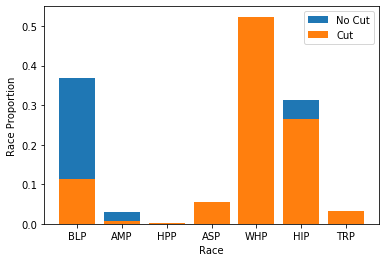

In [59]:
p1 = plt.bar(q2_nocut.index[9:], q2_nocut[9:])
p2 = plt.bar(q2_cut.index[9:], q2_cut[9:])


plt.xlabel('Race')
plt.ylabel('Race Proportion')
plt.legend([p1, p2], ['No Cut', 'Cut'])

plt.savefig('Q2.png')

plt.show()

# Problem 3
#### Calculate the proportion of enrolled students by disability status (students with an IEP under IDEA) for each district, then visualize the distributions of these proportions for districts that received budget cuts versus districts that did not receive budget cuts. Comment on whether the the distributions appear to be the same or different. Did your selection include any hidden biases, or manage to avoid them?

In [61]:
q3 = pd.merge(budget_cuts, disable, on='LEAID')
q3.head()

,LEAID,CENSUSID,FIPST_x,CONUM,CSA,CBSA,NAME,STNAME,STABBR,SCHLEV,...,BudgetCutProp,InvBudgetCutProp,SURVYEAR,FIPST_y,STABR,STATENAME,SEANAME,ST_LEAID,LEA_NAME,SPECED
0,2600121,N,26,26161,220,11460,Honey Creek Community School,Michigan,MI,01,...,0.549405,0.450595,2015-2016,26,MI,MICHIGAN,MI Dept of Ed (MDE) & MI Center for Ed Perf an...,81901,Honey Creek Community School,39
1,2601042,N,26,26163,220,19820,Branch Line School,Michigan,MI,01,...,0.547190,0.452810,2015-2016,26,MI,MICHIGAN,MI Dept of Ed (MDE) & MI Center for Ed Perf an...,82705,Branch Line School,11
2,3004920,27505640230200,30,30111,N,13740,Broadview H S,Montana,MT,02,...,0.529460,0.470540,2015-2016,30,MT,MONTANA,Montana Office of Public Instruction,0979,Broadview H S,7
3,400771,N,4,04019,536,46060,Blue Adobe Project,Arizona,AZ,02,...,0.520225,0.479775,2015-2016,4,AZ,ARIZONA,Arizona Department of Education,89871,Blue Adobe Project,10
4,400902,N,4,04013,N,38060,The Farm at Mission Montessori Academy,Arizona,AZ,01,...,0.519855,0.480145,2015-2016,4,AZ,ARIZONA,Arizona Department of Education,91340,The Farm at Mission Montessori Academy,5


In [62]:
q3_nocut = q3[q3['BudgetCutProp'] == 0]
q3_cut = q3[q3['BudgetCutProp'] > 0]


q3_nocut = q3_nocut[['V33', 'SPECED']]
q3_cut = q3_cut[['V33', 'SPECED']]


q3_nocut['NOSPECED'] = q3_nocut['V33'] - q3_nocut['SPECED']
q3_cut['NOSPECED'] = q3_cut['V33'] - q3_cut['SPECED']

In [67]:
q3_nocut = q3_nocut.sum()
q3_cut = q3_cut.sum()

q3_nocut['NOSPECEDR'] = q3_nocut['NOSPECED'] / q3_nocut['V33']
q3_nocut['SPECEDR'] = q3_nocut['SPECED'] / q3_nocut['V33']

q3_cut['NOSPECEDR'] = q3_cut['NOSPECED'] / q3_cut['V33']
q3_cut['SPECEDR'] = q3_cut['SPECED'] / q3_cut['V33']

<BarContainer object of 2 artists>

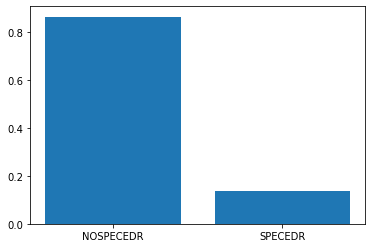

In [74]:
plt.bar(q3_nocut.index[3:], q3_nocut.values[3:])

<BarContainer object of 2 artists>

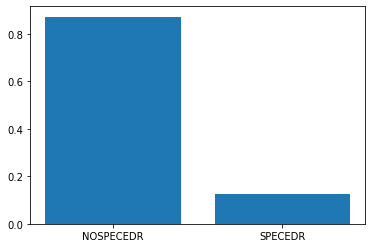

In [75]:
plt.bar(q3_cut.index[3:], q3_cut.values[3:])